Implementação da rede neural convolucional

Treinamento, avaliação e interpretação do modelo

1. Carregando dados...
   Dados carregados. Shape original: (918, 12)
2. Pré-processando...
   Shape após encoding: (918, 15)
3. Iniciando Treinamento (5 Folds)...
   [Debug] Input Shape para a CNN: (15, 1)


/home/matheus/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   Fold 1: Acurácia = 0.8750


/home/matheus/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   Fold 2: Acurácia = 0.8696


/home/matheus/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   Fold 3: Acurácia = 0.8750


/home/matheus/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   Fold 4: Acurácia = 0.8197


/home/matheus/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   Fold 5: Acurácia = 0.8798

4. Gerando Gráficos...
   Acurácia Média Final: 86.38%


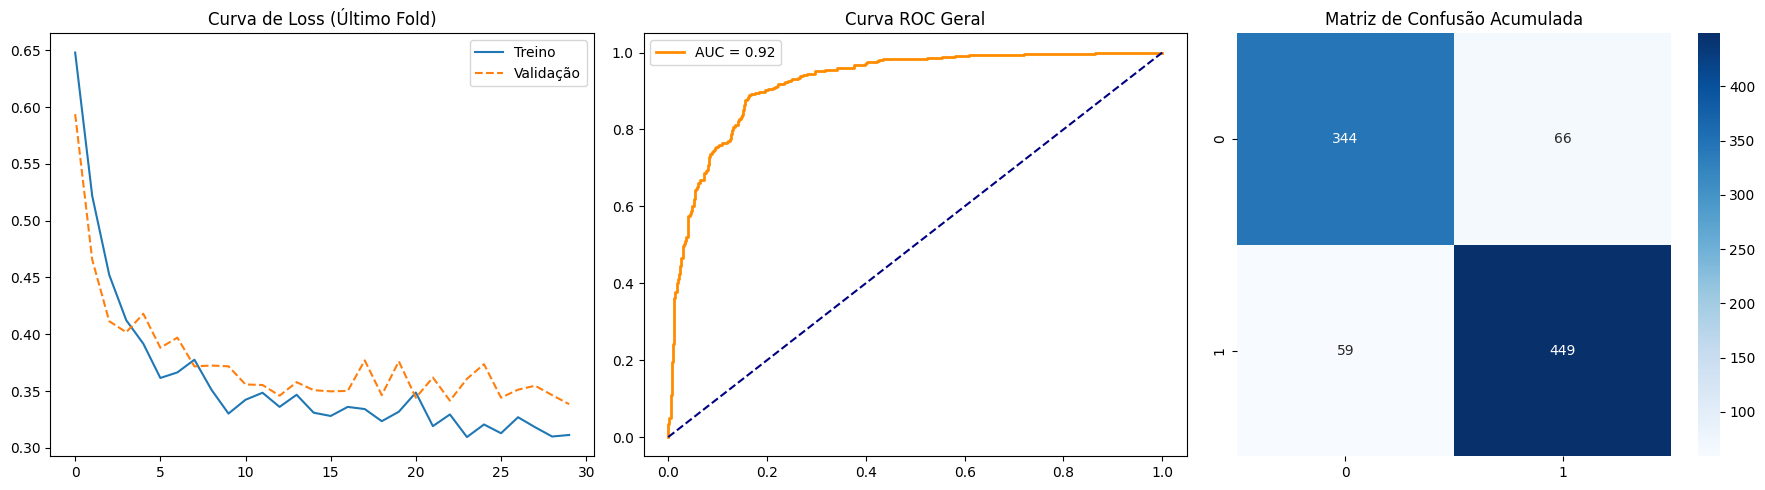

Concluído com sucesso!


In [ ]:
# --- CÉLULA ÚNICA E COMPLETA  ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os

print("1. Carregando dados...")
if not os.path.exists('heart.csv'):
    print("ERRO CRÍTICO: O arquivo 'heart.csv' não foi encontrado. Faça o upload novamente.")
else:
    df = pd.read_csv('heart.csv')
    print(f"   Dados carregados. Shape original: {df.shape}")

    # Pré-processamento 
    print("2. Pré-processando...")
    X = df.drop('HeartDisease', axis=1)
    y = df['HeartDisease']
    X = pd.get_dummies(X, drop_first=True)
    print(f"   Shape após encoding: {X.shape}")

    # Configuração do K-Fold
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Listas para métricas
    acc_scores, f1_scores = [], []
    y_true_all, y_pred_prob_all, y_pred_class_all = [], [], []
    history_last_fold = None

    print("3. Iniciando Treinamento (5 Folds)...")
    fold_no = 1
    
    try:
        for train_index, test_index in kfold.split(X):
            # Divisão
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Escalonamento
            scaler = StandardScaler()
            pt = PowerTransformer()
            
            # Fit apenas no treino para evitar vazamento
            X_train_scaled = pt.fit_transform(scaler.fit_transform(X_train))
            X_test_scaled = pt.transform(scaler.transform(X_test))
            
            # Reshape para CNN (Samples, Features, 1)
            X_train_cnn = np.expand_dims(X_train_scaled, axis=-1)
            X_test_cnn = np.expand_dims(X_test_scaled, axis=-1)
            
            if fold_no == 1:
                print(f"   [Debug] Input Shape para a CNN: {X_train_cnn.shape[1:]}")

            # Definição do Modelo 
            model = Sequential([
                Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
                MaxPooling1D(pool_size=2),
                Dropout(0.2),
                Conv1D(filters=64, kernel_size=2, activation='relu'),
                MaxPooling1D(pool_size=2),
                Dropout(0.2),
                Flatten(),
                Dense(64, activation='relu'),
                Dropout(0.3),
                Dense(1, activation='sigmoid')
            ])
            
            model.compile(optimizer=Adam(learning_rate=0.001),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
            
            # Treinamento
            history = model.fit(X_train_cnn, y_train, 
                                epochs=30, 
                                batch_size=32, 
                                validation_data=(X_test_cnn, y_test),
                                verbose=0)
            
            history_last_fold = history # Salva para plotar depois

            # Predições
            y_prob = model.predict(X_test_cnn, verbose=0).flatten()
            y_class = (y_prob > 0.5).astype(int)
            
            # Métricas do fold
            acc = accuracy_score(y_test, y_class)
            acc_scores.append(acc)
            f1_scores.append(f1_score(y_test, y_class))
            
            y_true_all.extend(y_test)
            y_pred_prob_all.extend(y_prob)
            y_pred_class_all.extend(y_class)
            
            print(f"   Fold {fold_no}: Acurácia = {acc:.4f}")
            fold_no += 1
            
        print("\n4. Gerando Gráficos...")
        print(f"   Acurácia Média Final: {np.mean(acc_scores)*100:.2f}%")

        # Plotagem
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Loss
        if history_last_fold:
            axes[0].plot(history_last_fold.history['loss'], label='Treino')
            axes[0].plot(history_last_fold.history['val_loss'], label='Validação', linestyle='--')
            axes[0].set_title('Curva de Loss (Último Fold)')
            axes[0].legend()
        
        # ROC
        fpr, tpr, _ = roc_curve(y_true_all, y_pred_prob_all)
        roc_auc = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
        axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
        axes[1].set_title('Curva ROC Geral')
        axes[1].legend()

        # Matriz de Confusão
        cm = confusion_matrix(y_true_all, y_pred_class_all)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2])
        axes[2].set_title('Matriz de Confusão Acumulada')

        plt.tight_layout()
        plt.show()
        print("Concluído com sucesso!")

    except Exception as e:
        print(f"\n--- ERRO DETECTADO ---")
        print(f"Ocorreu um erro durante o processamento: {e}")
        print("DICA: Se o erro for 'shapes mismatch', verifique se o 'get_dummies' gerou o número esperado de colunas.")